# MODELOS LOGÍSTICOS BINÁRIOS E MULTINOMIAIS

MBA DATA SCIENCE & ANALYTICS USP/ESALQ

UNIVERSIDADE DE SÃO PAULO

Prof. Dr. Luiz Paulo Fávero

In [3]:
# Instalação dos pacotes.

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install statstests

In [44]:
# Importação dos pacotes.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy import stats
import plotly.graph_objects as go
from statsmodels.iolib.summary2 import summary_col
from statsmodels.discrete.discrete_model import MNLogit
from math import exp
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

## CURVA SIGMOIDE
Estabelecendo uma função para a probabilidade de ocorrência de um evento.

In [5]:
# Estabelecendo uma função para a probabilidade de ocorrência de um evento.
def prob(z):
    return 1 / (1 + exp(-z))

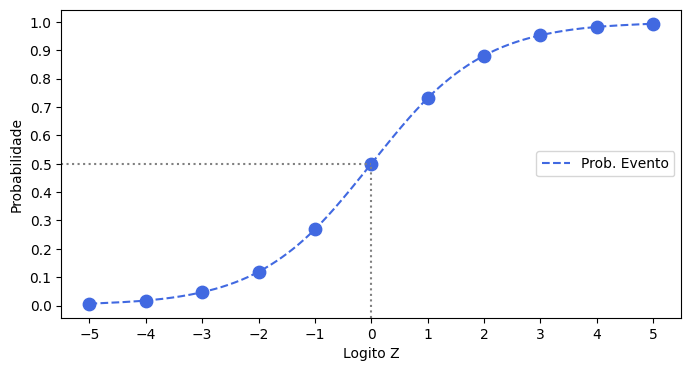

In [9]:
# Plotando a curva sigmoide teórica de ocorrência de um evento para um range do logito z entre -5 e +5.

logitos = []
probs = []

for i in np.arange(-5, 6):
    logitos.append(i)
    probs.append(prob(i))
    
df = pd.DataFrame({'logito': logitos, 'probs': probs})

# Interpolação spline (smooth probability line)
spline = UnivariateSpline(df['logito'], df['probs'], s=0)

logitos_smooth = np.linspace(df['logito'].min(), df['logito'].max(), 500)
probs_smooth = spline(logitos_smooth)

plt.figure(figsize=(8,4))
plt.plot(logitos_smooth, probs_smooth, color='royalblue',
         linestyle='--', label='Prob. Evento')
plt.scatter(df['logito'], df['probs'], color='royalblue', marker='o', s=80)
plt.axhline(y = df.probs.mean(), color = 'grey', linestyle = ':', xmax = .5)
plt.axvline(x = 0, color = 'grey', linestyle=':', ymax = 0.5)
plt.xlabel("Logito Z", fontsize=10)
plt.ylabel("Probabilidade", fontsize=10)
plt.xticks(np.arange(-5, 6), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)
plt.legend(fontsize=10, loc='center right')
plt.show()

# **REGRESSÃO LOGÍSTICA BINÁRIA**

In [10]:
# Carregamento da base de dados.
url = 'https://raw.githubusercontent.com/filipecarbonera/MBA_USP_Data_Science_Analytics/refs/heads/main/Modelos%20Log%C3%ADsticos%20Bin%C3%A1rios%20e%20Multinomiais/Dados/atrasado.csv'

df_atrasado = pd.read_csv(url, delimiter=',')
df_atrasado.head()

,estudante,atrasado,dist,sem
0,Gabriela,0,12.5,7
1,Patricia,0,13.3,10
2,Gustavo,0,13.4,8
3,Leticia,0,23.5,7
4,Luiz Ovidio,0,9.5,8


In [11]:
# Características das variáveis do dataset.
df_atrasado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    int64  
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


In [12]:
# Estatísticas univariadas.
df_atrasado.describe()

,atrasado,dist,sem
count,100.000000,100.000000,100.000000
mean,0.590000,14.073000,10.210000
std,0.494311,4.330112,1.578229
min,0.000000,1.000000,5.000000
25%,0.000000,12.000000,10.000000
50%,1.000000,13.350000,10.000000
75%,1.000000,16.125000,10.000000
max,1.000000,29.000000,18.000000


In [13]:
# Tabela de frequências absolutas da variável 'atrasado'.
df_atrasado['atrasado'].value_counts().sort_index()

atrasado
0    41
1    59
Name: count, dtype: int64

In [16]:
# Estimação de um modelo logístico binário pela função 'smf.glm' ('statsmodels.formula.api').
modelo_atrasos = smf.glm(formula='atrasado ~ dist + sem', data=df_atrasado, family=sm.families.Binomial()).fit()

# Parâmetros do 'modelo_atrasos'.
modelo_atrasos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               atrasado   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.466
Date:                Mon, 30 Sep 2024   Deviance:                       100.93
Time:                        00:19:52   Pearson chi2:                     86.7
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2913
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.1665      8.442     -3.100      0.002     -42.712      -9.621
dist           0.1904      0.076      2.493      0.013       0.041       0.340
sem            2.3629      0.795      2.972      0.003       0.804       3.921
==============================================================================
"""

In [17]:
# Outputs do modelo pela função 'summary_col'.
summary_col([modelo_atrasos], model_names=["MODELO"], stars=True,
            info_dict = {'N':lambda x: "{0:d}".format(int(x.nobs)),'Log-lik':lambda x: "{:.3f}".format(x.llf)})

,MODELO
Intercept,-26.1665***
,(8.4420)
dist,0.1904**
,(0.0764)
sem,2.3629***
,(0.7951)
N,100
Log-lik,-50.466


In [18]:
# Fazendo predições para o 'modelo_atrasos'.

# Exemplo: Qual a probabilidade média de se chegar atrasado quando o trajeto tem 7 km e passa-se por 10 semáforos no percurso?
modelo_atrasos.predict(pd.DataFrame({'dist':[7], 'sem':[10]}))

0    0.230566
dtype: float64

In [21]:
# Construção de uma matriz de confusão.

# Adicionando os valores previstos de probabilidade na base de dados.
df_atrasado['phat'] = modelo_atrasos.predict()

# Visualização da base de dados com a variável 'phat'.
df_atrasado.head()

,estudante,atrasado,dist,sem,phat
0,Gabriela,0,12.5,7,0.000712
1,Patricia,0,13.3,10,0.498561
2,Gustavo,0,13.4,8,0.008903
3,Leticia,0,23.5,7,0.005751
4,Luiz Ovidio,0,9.5,8,0.004257


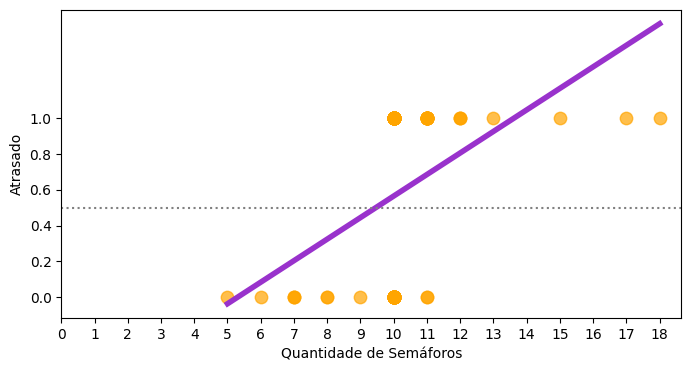

In [25]:
# Apenas para fins didáticos.

# Gráficos com ajustes entre a variável dependente e a variável 'sem'.
# Ajuste linear entre a variável dependente e a variável 'sem' (Gráfico errado:

plt.figure(figsize=(8,4))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'],
            ci=None, marker='o',
            scatter_kws={'color':'orange', 's':80, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':4})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=10)
plt.ylabel('Atrasado', fontsize=10)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.show()

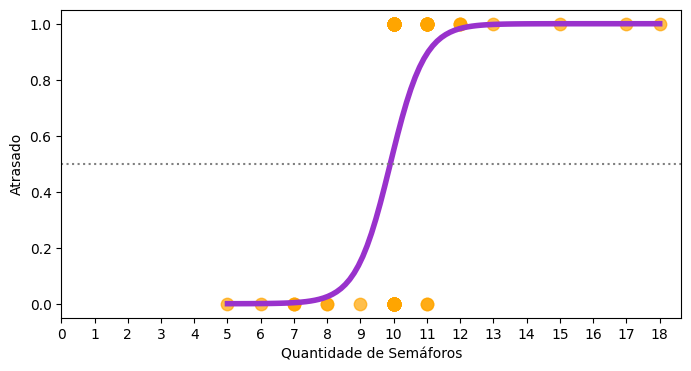

In [30]:
# Ajuste logístico determinístico entre a variável dependente e a variável 'sem'.
# Sigmoide.

plt.figure(figsize=(8,4))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['atrasado'],
            ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':80, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':4})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=10)
plt.ylabel('Atrasado', fontsize=10)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.show()

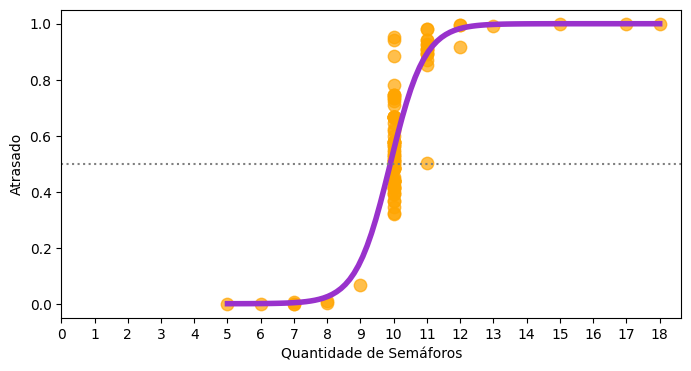

In [31]:
# Ajuste logístico probabilístico entre a variável dependente e a variável 'sem'.
# Sigmoide.

plt.figure(figsize=(8,4))
sns.regplot(x=df_atrasado['sem'], y=df_atrasado['phat'],
            ci=None, marker='o', logistic=True,
            scatter_kws={'color':'orange', 's':80, 'alpha':0.7},
            line_kws={'color':'darkorchid', 'linewidth':4})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Quantidade de Semáforos', fontsize=10)
plt.ylabel('Atrasado', fontsize=10)
plt.xticks(np.arange(0, df_atrasado['sem'].max() + 0.01),
           fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.show()

In [33]:
# Construção de função para a definição da matriz de confusão.

from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    # Visualização dos principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade], 'Especificidade':[especificidade], 'Acurácia':[acuracia]})
    return indicadores

**Matrizes de confusão propriamente ditas.**

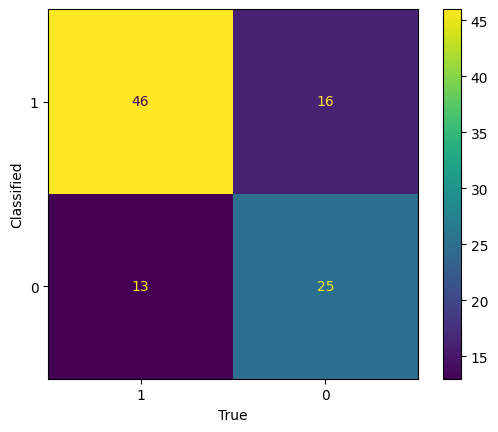

,Sensitividade,Especificidade,Acurácia
0,0.779661,0.609756,0.71


In [35]:
# Matriz de confusão para cutoff = 0.5.
matriz_confusao(observado=df_atrasado['atrasado'], predicts=df_atrasado['phat'],  cutoff=0.5)

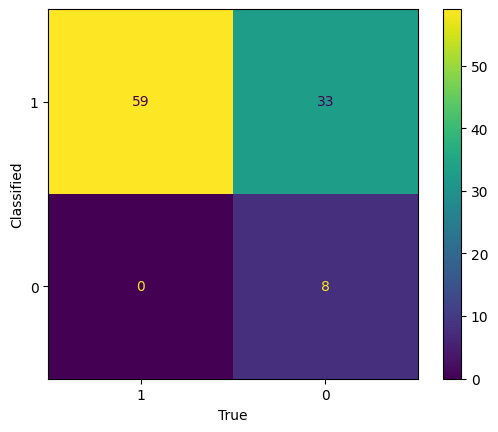

,Sensitividade,Especificidade,Acurácia
0,1.0,0.195122,0.67


In [36]:
# Matriz de confusão para cutoff = 0.3.
matriz_confusao(observado=df_atrasado['atrasado'], predicts=df_atrasado['phat'],  cutoff=0.3)

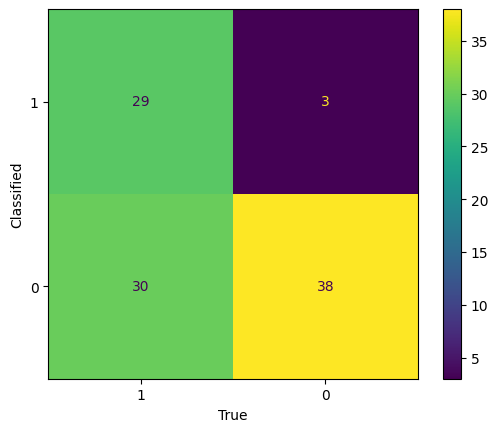

,Sensitividade,Especificidade,Acurácia
0,0.491525,0.926829,0.67


In [37]:
# Matriz de confusão para cutoff = 0.7.
matriz_confusao(observado=df_atrasado['atrasado'], predicts=df_atrasado['phat'],  cutoff=0.7)

**Igualando critérios de especificidade e de sensitividade**

Tentaremos estabelecer um critério que iguale a probabilidade de acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de acerto daqueles que não chegarão atrasados (especificidade).

**ATENÇÃO:** o que será feito a seguir possui fins didáticos, apenas.
DE NENHUMA FORMA, o procedimento garante a maximização da acurácia do modelo!

In [38]:
# Criação da função 'espec_sens' para a construção de um dataset com diferentes valores de cutoff, sensitividade e especificidade:
def espec_sens(observado,predicts):
    
    # Adicionar objeto com os valores dos predicts.
    values = predicts.values
    
    # Range dos cutoffs a serem analisados em steps de 0.01.
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade.
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict.
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff.
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas.
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs.
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [40]:
# Até o momento, foram extraídos 3 vetores: 'sensitividade', 'especificidade' e 'cutoffs'.
# Assim, criamos um dataframe que contém os vetores mencionados (dataframe 'dados_plotagem').

dados_plotagem = espec_sens(observado = df_atrasado['atrasado'], predicts = df_atrasado['phat'])
dados_plotagem.head()

,cutoffs,sensitividade,especificidade
0,0.00,1.0,0.000000
1,0.01,1.0,0.170732
2,0.02,1.0,0.170732
3,0.03,1.0,0.170732
4,0.04,1.0,0.170732


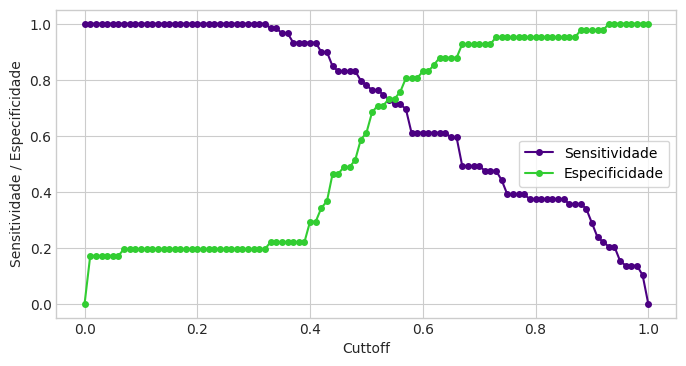

In [43]:
# Plotagem de um gráfico que mostra a variação da especificidade e da sensitividade em função do cutoff.

plt.figure(figsize=(8,4))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o', color='indigo', markersize=4)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o', color='limegreen', markersize=4)
plt.xlabel('Cuttoff', fontsize=10)
plt.ylabel('Sensitividade / Especificidade', fontsize=10)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=10)
plt.show()

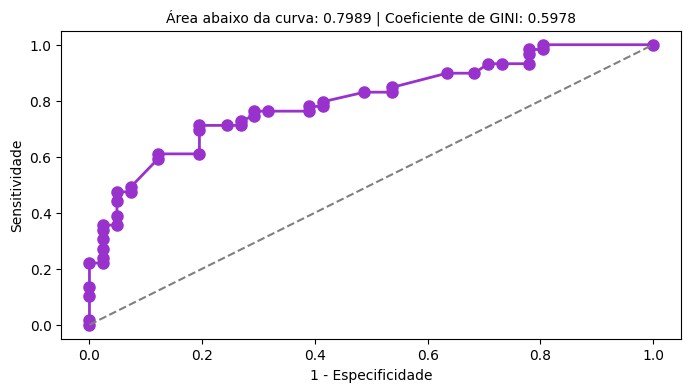

In [49]:
# Construção da curva ROC.

fpr, tpr, thresholds =roc_curve(df_atrasado['atrasado'], df_atrasado['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI.
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC.
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=8, linewidth=2)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) + ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=10)
plt.xlabel('1 - Especificidade', fontsize=10)
plt.ylabel('Sensitividade', fontsize=10)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.show()

# **REGRESSÃO LOGÍSTICA BINÁRIA E PROCEDIMENTO STEPWISE**

In [56]:
# Carregamento da base de dados.
url = 'https://raw.githubusercontent.com/filipecarbonera/MBA_USP_Data_Science_Analytics/refs/heads/main/Modelos%20Log%C3%ADsticos%20Bin%C3%A1rios%20e%20Multinomiais/Dados/challenger.csv'

df_challenger = pd.read_csv(url, delimiter=',')
df_challenger.head()

,desgaste,temperatura,pressao,t
0,0,66,50,1
1,1,70,50,2
2,0,69,50,3
3,0,68,50,4
4,0,67,50,5


In [58]:
# Características das variáveis do dataset.
df_challenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressao      23 non-null     int64
 3   t            23 non-null     int64
dtypes: int64(4)
memory usage: 864.0 bytes


In [59]:
# Estatísticas univariadas.
df_challenger.describe()

,desgaste,temperatura,pressao,t
count,23.000000,23.000000,23.000000,23.00000
mean,0.304348,69.565217,152.173913,12.00000
std,0.558796,7.057080,68.221332,6.78233
min,0.000000,53.000000,50.000000,1.00000
25%,0.000000,67.000000,75.000000,6.50000
50%,0.000000,70.000000,200.000000,12.00000
75%,0.500000,75.000000,200.000000,17.50000
max,2.000000,81.000000,200.000000,23.00000


**desgaste:** quantidade de vezes em que ocorreu stress térmico.

**temperatura:** temperatura de lançamento (graus ºF).

**pressão:** pressão de verificação de vazamento (psi: libra-força por polegada ao quadrado).

**t:** teste para o lançamento (id).

In [60]:
# Criação da variável dependente binária 'falha'.

# Não há uma variável binária para servir como uma variável dependente, certo?
# Então vamos criá-la, considerando a ocorrência de desgastes de peças como a ocorrência de um evento que chamaremos de 'falha':
df_challenger.loc[df_challenger['desgaste'] != 0 , 'falha'] = 1
df_challenger.loc[df_challenger['desgaste'] == 0, 'falha'] = 0

Transformando a variável 'falha' para o tipo 'int' (poderia também deixar como 'float'), a fim de que seja possível estimar o modelo por meio da função 'sm.Logit.from_formula'.

In [62]:
df_challenger.info()

df_challenger['falha'] = df_challenger['falha'].astype('int64')

df_challenger.info()

df_challenger.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressao      23 non-null     int64
 3   t            23 non-null     int64
 4   falha        23 non-null     int64
dtypes: int64(5)
memory usage: 1.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressao      23 non-null     int64
 3   t            23 non-null     int64
 4   falha        23 non-null     int64
dtypes: int64(5)
memory usage: 1.0 KB


,desgaste,temperatura,pressao,t,falha
0,0,66,50,1,0
1,1,70,50,2,1
2,0,69,50,3,0
3,0,68,50,4,0
4,0,67,50,5,0


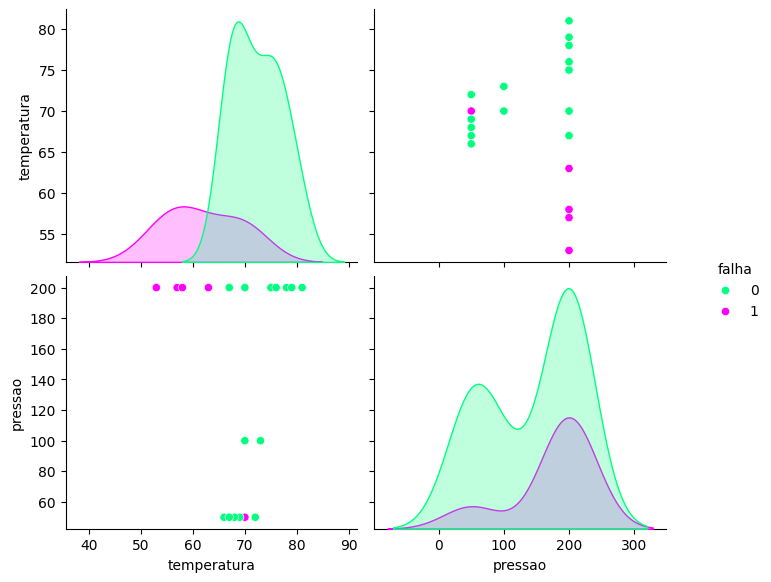

In [64]:
# Gráfico 'pairplot' com scatters e KDEs por 'falha'.

cores_desejadas = {0: 'springgreen', 1: 'magenta'}

g = sns.pairplot(df_challenger[['falha','temperatura','pressao']], hue='falha', palette=cores_desejadas)
g.fig.set_size_inches(8, 6)
plt.show()

In [66]:
# Estimação do modelo logístico binário pela função 'sm.Logit.from_formula' ('statsmodels.api').
# O modelo a seguir também pode ser estimado por meio da função 'smf.glm' ('statsmodels.formula.api').
modelo_challenger = sm.Logit.from_formula('falha ~ temperatura + pressao', df_challenger).fit()

# Parâmetros do 'modelo_challenger'.
modelo_challenger.summary()

Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                  0.4685
Time:                        00:44:29   Log-Likelihood:                -7.0164
converged:                       True   LL-Null:                       -13.201
Covariance Type:            nonrobust   LLR p-value:                  0.002061
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      21.8436     11.936      1.830      0.067      -1.551      45.239
temperatura    -0.3501      0.173     -2.024      0.043      -0.689      -0.011
pressao         0.0060      0.010      0.616      0.538      -0.013       0.025
===============================================================================
"""